# **Libraries**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# **Load Dataset**

In [2]:
df = pd.read_excel("RFM Analysis.xlsx")
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


# **Structure Check**


*  The dataset contains transaction-level records including customer, product, pricing, and transaction status information.


In [3]:
df.shape

(20000, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [6]:
df.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

# **Data Cleaning**

### Duplicate Records

In [7]:
df.duplicated().sum()

np.int64(0)

### Missing Values


*   Critical missing values were removed, while non-critical categorical fields were imputed safely



In [8]:
df.isnull().sum()

,0
transaction_id,0
product_id,0
customer_id,0
transaction_date,0
online_order,360
order_status,0
brand,197
product_line,197
product_class,197
product_size,197


In [9]:
df.fillna('Unknown', inplace=True)

/tmp/ipython-input-2825310197.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('Unknown', inplace=True)


In [10]:
df.isnull().sum()

,0
transaction_id,0
product_id,0
customer_id,0
transaction_date,0
online_order,0
order_status,0
brand,0
product_line,0
product_class,0
product_size,0


# **EDA**

Order Status

In [11]:
df['order_status'].value_counts()

,count
order_status,
Approved,19821
Cancelled,179


In [12]:
df.groupby('order_status')['list_price'].sum()

,list_price
order_status,
Approved,21954196.69
Cancelled,202392.29


In [13]:
df = df[df['order_status'] == 'Approved']

Distribution of Revenue

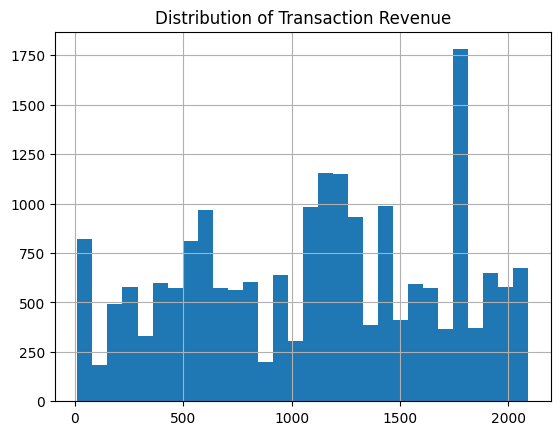

In [14]:
df['list_price'].hist(bins=30)
plt.title("Distribution of Transaction Revenue")
plt.show()

Revenue by Brand

In [15]:
df.groupby('brand')['list_price'].sum().sort_values(ascending=False).head(10)

,list_price
brand,
Solex,4446888.35
WeareA2B,4126372.83
Giant Bicycles,4055613.05
Trek Bicycles,3512223.81
OHM Cycles,2965459.80
Norco Bicycles,2632937.45
Unknown,214701.40


Pareto Analysis


*   A small proportion of transactions contributes to the majority of total revenue, confirming the Pareto principle



In [16]:
df_sorted = df.sort_values(by='list_price', ascending=False).reset_index(drop=True)

In [17]:
df_sorted['cumulative_revenue'] = df_sorted['list_price'].cumsum()
df_sorted['revenue_percentage'] = df_sorted['cumulative_revenue'] / df_sorted['list_price'].sum()

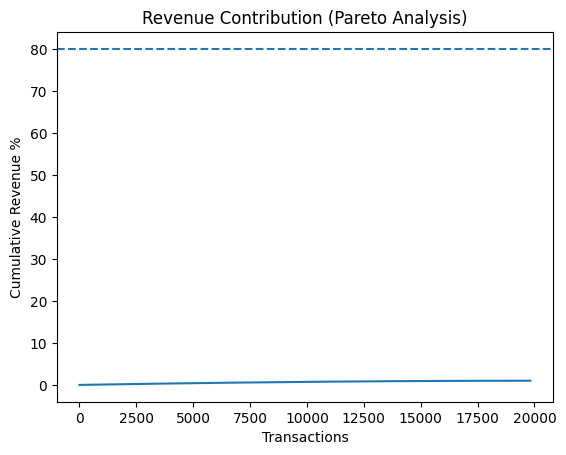

In [18]:
plt.plot(df_sorted['revenue_percentage'])
plt.axhline(80, linestyle='--')
plt.xlabel("Transactions")
plt.ylabel("Cumulative Revenue %")
plt.title("Revenue Contribution (Pareto Analysis)")
plt.show()

In [19]:
df_sorted['revenue_percentage'].iloc[-1]

np.float64(1.0000000000000162)

In [20]:
df_sorted['revenue_percentage'] = (
    df_sorted['cumulative_revenue'] / df_sorted['list_price'].sum()
) * 100

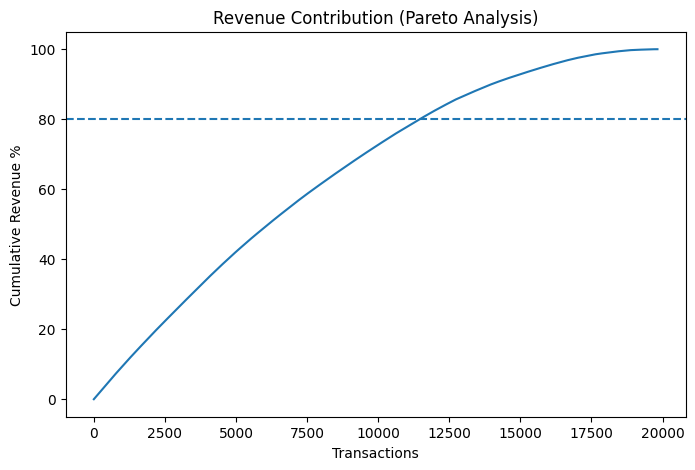

In [21]:
plt.figure(figsize=(8,5))
plt.plot(df_sorted['revenue_percentage'])
plt.axhline(80, linestyle='--')
plt.xlabel("Transactions")
plt.ylabel("Cumulative Revenue %")
plt.title("Revenue Contribution (Pareto Analysis)")
plt.show()

# **Feature Engineering**

## Reference Date

In [22]:
reference_date = df['transaction_date'].max() + pd.Timedelta(days=1)

## Build RFM Table

In [23]:
rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,
    'transaction_id': 'count',
    'list_price': 'sum'
}).reset_index()

In [24]:
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,1,8,11,9084.45
1,2,129,3,4149.07
2,3,103,8,9888.23
3,4,196,2,1047.72
4,5,17,6,5903.20


## RFM Scores

In [25]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

In [26]:
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

In [27]:
rfm['Customer_Value'] = pd.qcut(
    rfm['RFM_Score'],
    3,
    labels=['Low', 'Medium', 'High']
)

# **Machine Learning**


*   Random Forest was selected for its robustness and ability to capture non-linear customer behavior patterns



In [29]:
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['Customer_Value']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [32]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
y_pred = model.predict(X_test)

In [34]:
accuracy_score(y_test, y_pred)

0.9413447782546495

In [35]:
confusion_matrix(y_test, y_pred)

array([[184,   0,  10],
       [  0, 224,  14],
       [  5,  12, 250]])

# **Export for Power BI**

In [36]:
rfm.to_csv("rfm_final.csv", index=False)